In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind


data_read = pd.read_csv('stud_math_1.csv')

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

data = data_read

data.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
350,MS,M,19,NaN,GT3,T,1.0,1.0,other,services,home,other,3.0,2.0,3.0,no,no,no,no,NaN,-6.0,yes,yes,no,5.0,4.0,4.0,2.0,8.0,NaN
268,GP,M,18,U,NaN,NaN,4.0,2.0,NaN,other,reputation,father,NaN,2.0,0.0,no,NaN,yes,yes,yes,-6.0,yes,yes,yes,5.0,4.0,5.0,5.0,10.0,50.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
334,GP,F,18,R,GT3,T,2.0,2.0,at_home,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,no,no,4.0,4.0,4.0,4.0,0.0,0.0
298,GP,F,18,U,GT3,NaN,4.0,3.0,other,other,reputation,father,1.0,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,3.0,3.0,0.0,70.0


In [ ]:
# цель проекта - изучить данные, очистить их и отобрать необходимые для построения модели.

In [2]:
# список количественных столбцов

quantitative = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'health', 'absences', 'score']

# список столбцов со строковыми данными

nominative = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
              'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# это список ниминативных столбцов для модели, добавил его сюда после анализа данных.

for_model = ['Mjob', 'address', 'higher', 'romantic']

count     378
unique      2
top         U
freq      295
Name: address, dtype: object

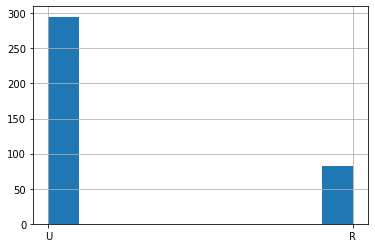

In [3]:
# колонки с номинативными данными оценивал по одной. на предмет лишних значений и опечаток.

data.address.hist()
data.address.describe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F141B9B448>,
      dtype=object)

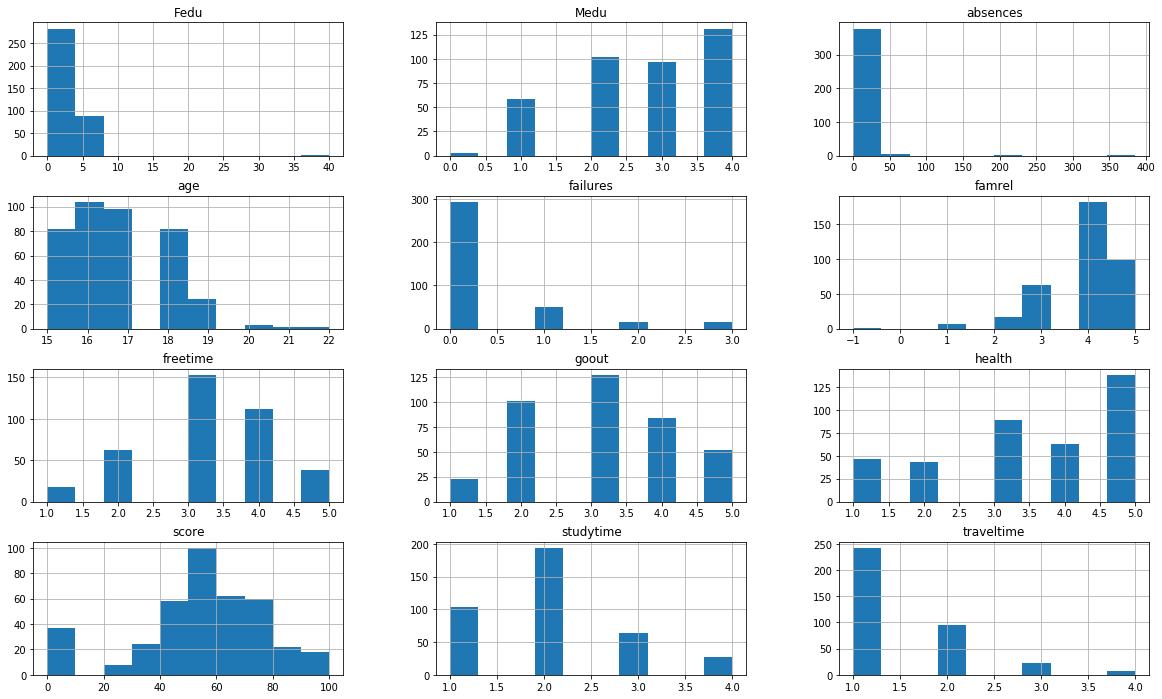

In [4]:
# Построим гистограммы по всем числовым колонкам, чтобы оценить вид распределения, а также, возможные ошибки и выбросы

data[quantitative].hist(figsize=(20, 12))

In [5]:
# корректировки, внесенные в набор данных после анализа.
# присутствует много пропущенных значений в разных колонках. я их так и оставил NAN
# для их заполнения недостаточно оснований.

# в столбце Fedu явная опечатка - 40, заменил на 4
data.Fedu = data.Fedu.apply(lambda x: x if x != 40 else 4)

# столбец famrel имеет ошибку - опечатку, а именно, значение -1.
# посчитал логичным заменить на 1
data.famrel = data.famrel.apply(lambda x: x if (x != -1) else 1)

# в столбце absences две явных опечатки. 212 считаю возможным заменить на 21, 385 - на 38.
# ученики с записями 212 и 385 ничем особо не выделяются и такие значения выглялят нелогичными.
# остальное рассмотрю более подробно.

data.absences = data.absences.apply(lambda x: x if (x != 212) else 21)
data.absences = data.absences.apply(lambda x: x if (x != 385) else 38)

25-й перцентиль: 11.0, 75-й перцентиль: 19.0, IQR: 8.0,  Границы выбросов: [-1.0, 31.0].


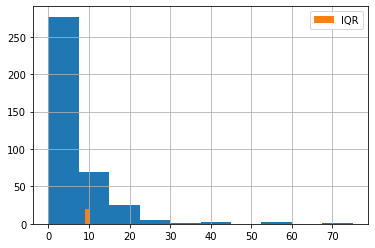

In [6]:
# absences

# если подходить к вопросу формально, то под выброс попадают значения выше 20.
# однако, такой результат обусловлен распределением данных в выборке - они сосредоточены в основном в районе нуля.

# так как 75% пропусков составляют 8 и ниже, я решил выбросы поискать, ограничив нижний диапазон количеством 8
# на мой взгляд, важно, что в этом случае нижняя граница выброса вплотную подходит к границе здравого смысла.
# можно было бы взять нижнюю границу 9 - тогда нижний выброс вообще положительный и <1, но верхний все равно 31.375

# получаем верхнюю границу выброса 31. выше этих значений всего 6 записей, причем одна из них заменена мною с 385 на 38

# есть также 38 и 40 пропусков, что в принципе возможно, может объясняться проблемами со здорьвьем, наличием романтических
# отношений и т.п., значения 54, 56 и 75 рассмотрю более подробно.

# 75 - дама явно не заинтересована в получении высокой оценки, не планирует учиться дальше, не получает доп образования
# состоит в романтических отношениях. отсюда, вероятно, много пропусков. оставлю 75.

# 56 - очень плохо со здоровьем у девушки, вполне могла поэтому много пропустить. оставлю 56.

# 54 - со здоровьем все в порядке, занимается дополнительно, вероятно, тоже опечатка но оставлю значение как есть.
# так как это не сильно отразится на результате.

data.absences.hist()

dataabc = data.loc[data.absences > 8]

median = dataabc.absences.median()
IQR = dataabc.absences.quantile(0.75) - dataabc.absences.quantile(0.25)
perc25 = dataabc.absences.quantile(0.25)
perc75 = dataabc.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
dataabc.absences.loc[dataabc.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(0, 10),
                                                                                        label='IQR')
plt.legend()

In [7]:
data.loc[data.absences > 31]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,38.0,85.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0
307,GP,M,19,U,GT3,NaN,4.0,4.0,teacher,services,reputation,other,2.0,1.0,1.0,no,yes,yes,no,yes,-3.0,yes,yes,yes,4.0,3.0,4.0,4.0,38.0,40.0
315,GP,F,19,R,GT3,T,2.0,3.0,other,other,reputation,other,1.0,3.0,1.0,no,no,no,no,yes,-9.0,yes,yes,yes,4.0,1.0,2.0,3.0,40.0,55.0


In [8]:
# посмотрим на таблицу корреляции

data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.161704,-0.163670,0.081508,-0.015556,0.228047,0.015556,0.067415,0.029023,0.135107,-0.065946,0.168179,-0.155726
Medu,-0.161704,1.000000,0.625516,-0.173515,0.078589,-0.245463,-0.078589,-0.014459,0.025335,0.064164,-0.045051,0.084351,0.213349
Fedu,-0.163670,0.625516,1.000000,-0.145349,0.012896,-0.272882,-0.012896,-0.026122,-0.025892,0.042663,0.023862,0.042005,0.130923
traveltime,0.081508,-0.173515,-0.145349,1.000000,-0.102206,0.064699,0.102206,-0.021542,-0.021937,0.037636,-0.021531,-0.023747,-0.070559
studytime,-0.015556,0.078589,0.012896,-0.102206,1.000000,-0.178992,-1.000000,0.039555,-0.121969,-0.051280,-0.080016,-0.066825,0.115741
failures,0.228047,-0.245463,-0.272882,0.064699,-0.178992,1.000000,0.178992,-0.009110,0.098382,0.120914,0.081284,0.074119,-0.344338
"studytime, granular",0.015556,-0.078589,-0.012896,0.102206,-1.000000,0.178992,1.000000,-0.039555,0.121969,0.051280,0.080016,0.066825,-0.115741
famrel,0.067415,-0.014459,-0.026122,-0.021542,0.039555,-0.009110,-0.039555,1.000000,0.172751,0.077167,0.086309,-0.068571,0.055305
freetime,0.029023,0.025335,-0.025892,-0.021937,-0.121969,0.098382,0.121969,0.172751,1.000000,0.296437,0.061575,-0.061218,0.019026
goout,0.135107,0.064164,0.042663,0.037636,-0.051280,0.120914,0.051280,0.077167,0.296437,1.000000,-0.015608,0.020285,-0.129685


In [9]:
# на мой взгляд, исходя из таблицы корреляции, лишний столбец только 'studytime, granular'

data.drop(['studytime, granular'], inplace=True, axis=1)

In [10]:
# построение боксплотов для визуальной оценки.


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=data,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

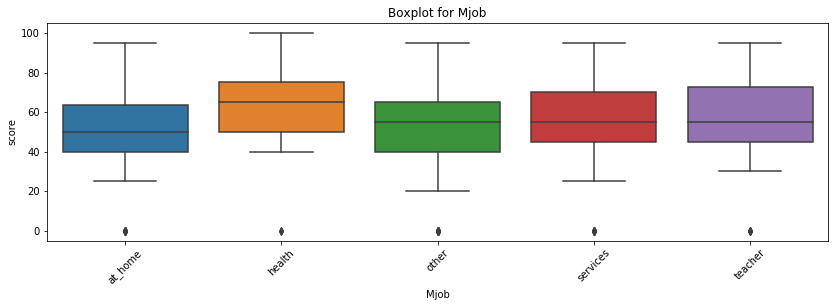

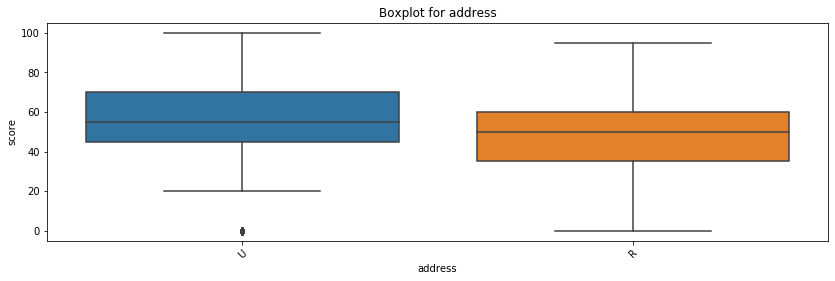

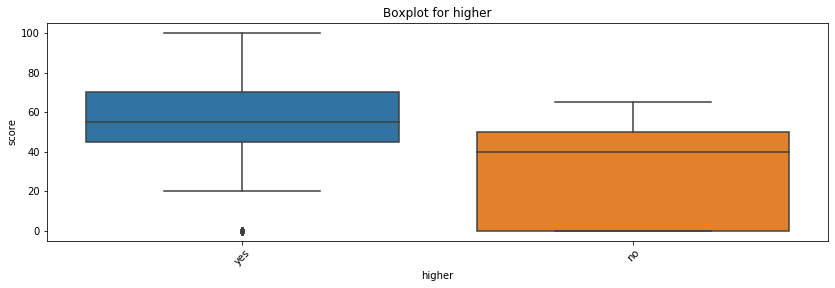

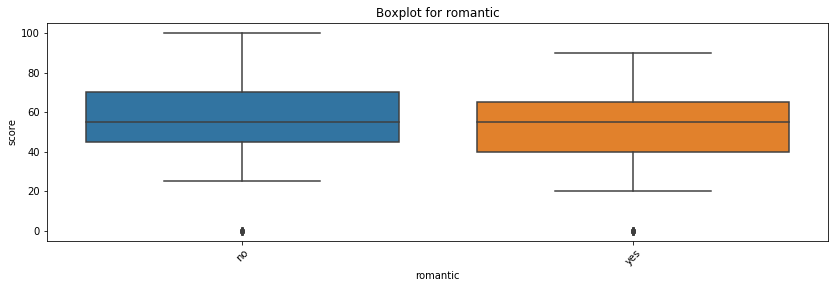

In [11]:
for col in for_model:
    get_boxplot(col)

In [12]:
# Поиск статистически значимых различий влияния номинативных параметров на результат теста.


def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'],
                     data.loc[data.loc[:, column] == comb[1], 'score'], nan_policy='omit').pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


for col in nominative:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [ ]:
# исходя из графиков казалось, что профессия отца также должна влиять.
# однако, кроме учителей никто из отцов не влияет на обучение, а учителей оказалось не очень много.

In [ ]:
# Выводы:

# данные в принципе достаточно чистые и удобоваримые. еще бы добавить немного внимательности тем, кто их вносит.
# самый проблеммный столбец - это absences - он единственный с ненормированными данными и в нем больше ошибок.

# что касается результатов. на мой взгляд, логично, что образование родителей и их профессии влияют на успеваемость ребенка
# удивительно, что род занятий папы оказался статистически незначимым.

# понятно, что количество времени на доп образование и репетиторы влияют на успеваемость. как и стремление учитсья дальше.

# в сельской местности у студентов, вероятно больше задач, потому и успеваемость ниже.

# ну и логично, что романтические отношения влияют на успеваемость не совсем в положительном ключе.

# что касается столбца failures - не совсем понятно, что это за неудачи, но студенты с меньшим их количеством имеют в среднем
# выше баллы. за исключением образования родителей, этот столбец имеет самую сильную корреляцию с score.